In [1]:
!pip install opendatasets --upgrade --quiet
!pip install kaggle --quiet

In [2]:
import opendatasets as od
import os
import random
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time

In [5]:
dataset_url = 'https://www.kaggle.com/datasets/mohammadhossein77/brain-tumors-dataset'
od.download(dataset_url)
data_dir = '/content/brain-tumors-dataset/Data'

def load_images_from_directory(directory):
    images, labels = [], []

    # Load images from the 'Normal' folder
    normal_path = os.path.join(directory, 'Normal')
    if os.path.isdir(normal_path):
        for file in os.listdir(normal_path):
            if file.endswith(".jpg"):

                image_path = os.path.join(normal_path, file)

                # Load and preprocess the image
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.resize(image, (32, 32))
                    image = img_to_array(image)
                    images.append(image)

                    # Label as 'Normal'
                    labels.append('Normal')

    # Load images from subfolders in the 'Tumor' folder
    tumor_path = os.path.join(directory, 'Tumor')
    if os.path.isdir(tumor_path):
        for subdir in os.listdir(tumor_path):
            subdir_path = os.path.join(tumor_path, subdir)
            if os.path.isdir(subdir_path):
                for file in os.listdir(subdir_path):
                    if file.endswith(".jpg"):
                        image_path = os.path.join(subdir_path, file)

                        # Load and preprocess the image
                        image = cv2.imread(image_path)
                        if image is not None:
                            image = cv2.resize(image, (32, 32))
                            image = img_to_array(image)
                            images.append(image)

                            # Use the subfolder name as the label
                            labels.append(subdir)

    # Convert to numpy arrays and normalize the images
    return np.array(images, dtype="float") / 255.0, np.array(labels)

# Load all images and labels
images, labels = load_images_from_directory(data_dir)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)

# Binarize the labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Check data loading and verify classes
print(f'Training samples: {len(x_train)}, Testing samples: {len(x_test)}')
print("Classes:", lb.classes_)

Skipping, found downloaded files in "./brain-tumors-dataset" (use force=True to force download)
Training samples: 17337, Testing samples: 4335
Classes: ['Normal' 'glioma_tumor' 'meningioma_tumor' 'pituitary_tumor']


In [6]:
def teacher_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Define the student model (fewer layers)
def student_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

input_shape = (32, 32, 3)  # Updated input shape
num_classes = len(lb.classes_)


In [9]:
teacher = teacher_model(input_shape, num_classes)
student = student_model(input_shape, num_classes)

# Define a learning rate scheduler function
def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1)) if epoch >= 10 else float(lr)

# Compile and train the teacher model
teacher.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
teacher.fit(x_train, y_train, batch_size=32, epochs=8, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Precompute teacher's predictions for distillation
teacher_preds = teacher.predict(x_train)

Epoch 1/8
542/542 ━━━━━━━━━━━━━━━━━━━━ 230s 420ms/step - accuracy: 0.4282 - loss: 1.2169 - val_accuracy: 0.6438 - val_loss: 0.8318 - learning_rate: 0.0100
Epoch 2/8
542/542 ━━━━━━━━━━━━━━━━━━━━ 249s 396ms/step - accuracy: 0.6793 - loss: 0.7575 - val_accuracy: 0.7548 - val_loss: 0.6527 - learning_rate: 0.0100
Epoch 3/8
542/542 ━━━━━━━━━━━━━━━━━━━━ 207s 383ms/step - accuracy: 0.7943 - loss: 0.5132 - val_accuracy: 0.8461 - val_loss: 0.3866 - learning_rate: 0.0100
Epoch 4/8
542/542 ━━━━━━━━━━━━━━━━━━━━ 274s 405ms/step - accuracy: 0.8718 - loss: 0.3322 - val_accuracy: 0.8934 - val_loss: 0.2883 - learning_rate: 0.0100
Epoch 5/8
542/542 ━━━━━━━━━━━━━━━━━━━━ 251s 386ms/step - accuracy: 0.9166 - loss: 0.2157 - val_accuracy: 0.9008 - val_loss: 0.2720 - learning_rate: 0.0100
Epoch 6/8
542/542 ━━━━━━━━━━━━━━━━━━━━ 264s 389ms/step - accuracy: 0.9518 - loss: 0.1334 - val_accuracy: 0.9421 - val_loss: 0.1834 - learning_rate: 0.0100
Epoch 7/8
542/542 ━━━━━━━━━━━━━━━━━━━━ 267s 398ms/step - accuracy: 0.9

In [10]:
def distillation_loss(y_true, y_pred, teacher_preds, temperature=5.0, alpha=0.3):
    teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
    y_true = tf.keras.activations.softmax(y_true / temperature)
    y_pred = tf.keras.activations.softmax(y_pred / temperature)
    teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)
    soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return alpha * soft_loss + (1. - alpha) * hard_loss

In [12]:
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

Teacher test accuracy: 93.06%


In [11]:
student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds), metrics=['accuracy'])
student.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

Epoch 1/25
542/542 ━━━━━━━━━━━━━━━━━━━━ 51s 90ms/step - accuracy: 0.4781 - loss: 1.3859 - val_accuracy: 0.7130 - val_loss: 1.3853 - learning_rate: 0.0010
Epoch 2/25
542/542 ━━━━━━━━━━━━━━━━━━━━ 51s 93ms/step - accuracy: 0.7327 - loss: 1.3852 - val_accuracy: 0.8328 - val_loss: 1.3849 - learning_rate: 0.0010
Epoch 3/25
542/542 ━━━━━━━━━━━━━━━━━━━━ 81s 92ms/step - accuracy: 0.8524 - loss: 1.3849 - val_accuracy: 0.8884 - val_loss: 1.3848 - learning_rate: 0.0010
Epoch 4/25
542/542 ━━━━━━━━━━━━━━━━━━━━ 82s 92ms/step - accuracy: 0.9026 - loss: 1.3847 - val_accuracy: 0.9031 - val_loss: 1.3847 - learning_rate: 0.0010
Epoch 5/25
542/542 ━━━━━━━━━━━━━━━━━━━━ 83s 94ms/step - accuracy: 0.9353 - loss: 1.3846 - val_accuracy: 0.9142 - val_loss: 1.3846 - learning_rate: 0.0010
Epoch 6/25
542/542 ━━━━━━━━━━━━━━━━━━━━ 80s 90ms/step - accuracy: 0.9585 - loss: 1.3845 - val_accuracy: 0.9276 - val_loss: 1.3846 - learning_rate: 0.0010
Epoch 7/25
542/542 ━━━━━━━━━━━━━━━━━━━━ 48s 89ms/step - accuracy: 0.9752 - l

In [13]:
# Evaluate models
#teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
student_score = student.evaluate(x_test, y_test, verbose=0)
#print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')
print(f'Student test accuracy: {student_score[1] * 100:.2f}%')

Student test accuracy: 95.80%


In [14]:
# Evaluate the teacher model
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)

print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

# Generate predictions from the teacher model
teacher_preds_probs = teacher.predict(x_test)
teacher_preds = np.argmax(teacher_preds_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print the classification report for the teacher model
print("=== Teacher Model Classification Report ===")
print(classification_report(y_true, teacher_preds, target_names=lb.classes_))

Teacher test accuracy: 93.06%
136/136 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step
=== Teacher Model Classification Report ===
                  precision    recall  f1-score   support

          Normal       0.96      0.97      0.96       613
    glioma_tumor       0.97      0.83      0.89      1262
meningioma_tumor       0.85      0.98      0.91      1278
 pituitary_tumor       0.98      0.97      0.97      1182

        accuracy                           0.93      4335
       macro avg       0.94      0.94      0.93      4335
    weighted avg       0.94      0.93      0.93      4335



In [15]:
alpha_values = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
f1_scores = []
accuracies = []
precisions = []
recalls = []
inference_times = []

teacher_preds = teacher.predict(x_train)

# Function to evaluate F1-score, accuracy, precision, recall, and inference time for a given model and alpha
def evaluate_student_with_alpha(alpha):
    # Redefine distillation loss function with current alpha
    def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=alpha):
        teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
        y_true = tf.keras.activations.softmax(y_true / temperature)
        y_pred = tf.keras.activations.softmax(y_pred / temperature)
        teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)
        soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
        hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        return alpha * soft_loss + (1. - alpha) * hard_loss

    # Compile the student model with the new distillation loss
    student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds),
                    metrics=['accuracy'])

    # Train the student model
    student.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test),
                callbacks=[LearningRateScheduler(lr_scheduler)], verbose=0)

    # Predict and evaluate
    start_time = time.time()
    y_pred_probs = student.predict(x_test)
    inference_time = time.time() - start_time
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate and store F1-score, accuracy, precision, recall, and inference time
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Append the results
    f1_scores.append(f1)
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    inference_times.append(inference_time)

    # Print classification report
    print(f"=== Classification Report for Alpha: {alpha} ===")
    print(classification_report(y_true, y_pred, target_names=lb.classes_))
    print(f"Inference Time: {inference_time:.4f} seconds\n")
    print(f"Alpha: {alpha} - F1 Score: {f1:.4f}, Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Run evaluation for each alpha
for alpha in alpha_values:
    evaluate_student_with_alpha(alpha)

542/542 ━━━━━━━━━━━━━━━━━━━━ 49s 91ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
=== Classification Report for Alpha: 0.0 ===
                  precision    recall  f1-score   support

          Normal       0.98      0.93      0.95       613
    glioma_tumor       0.90      0.95      0.92      1262
meningioma_tumor       0.95      0.88      0.91      1278
 pituitary_tumor       0.95      0.99      0.97      1182

        accuracy                           0.94      4335
       macro avg       0.94      0.94      0.94      4335
    weighted avg       0.94      0.94      0.94      4335

Inference Time: 3.2975 seconds

Alpha: 0.0 - F1 Score: 0.9375, Accuracy: 0.9377, Precision: 0.9387, Recall: 0.9377
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
=== Classification Report for Alpha: 0.05 ===
                  precision    recall  f1-score   support

          Normal       0.96      0.96      0.96       613
    glioma_tumor       0.94      0.92      0.93      1262
meningioma_tumor       0.

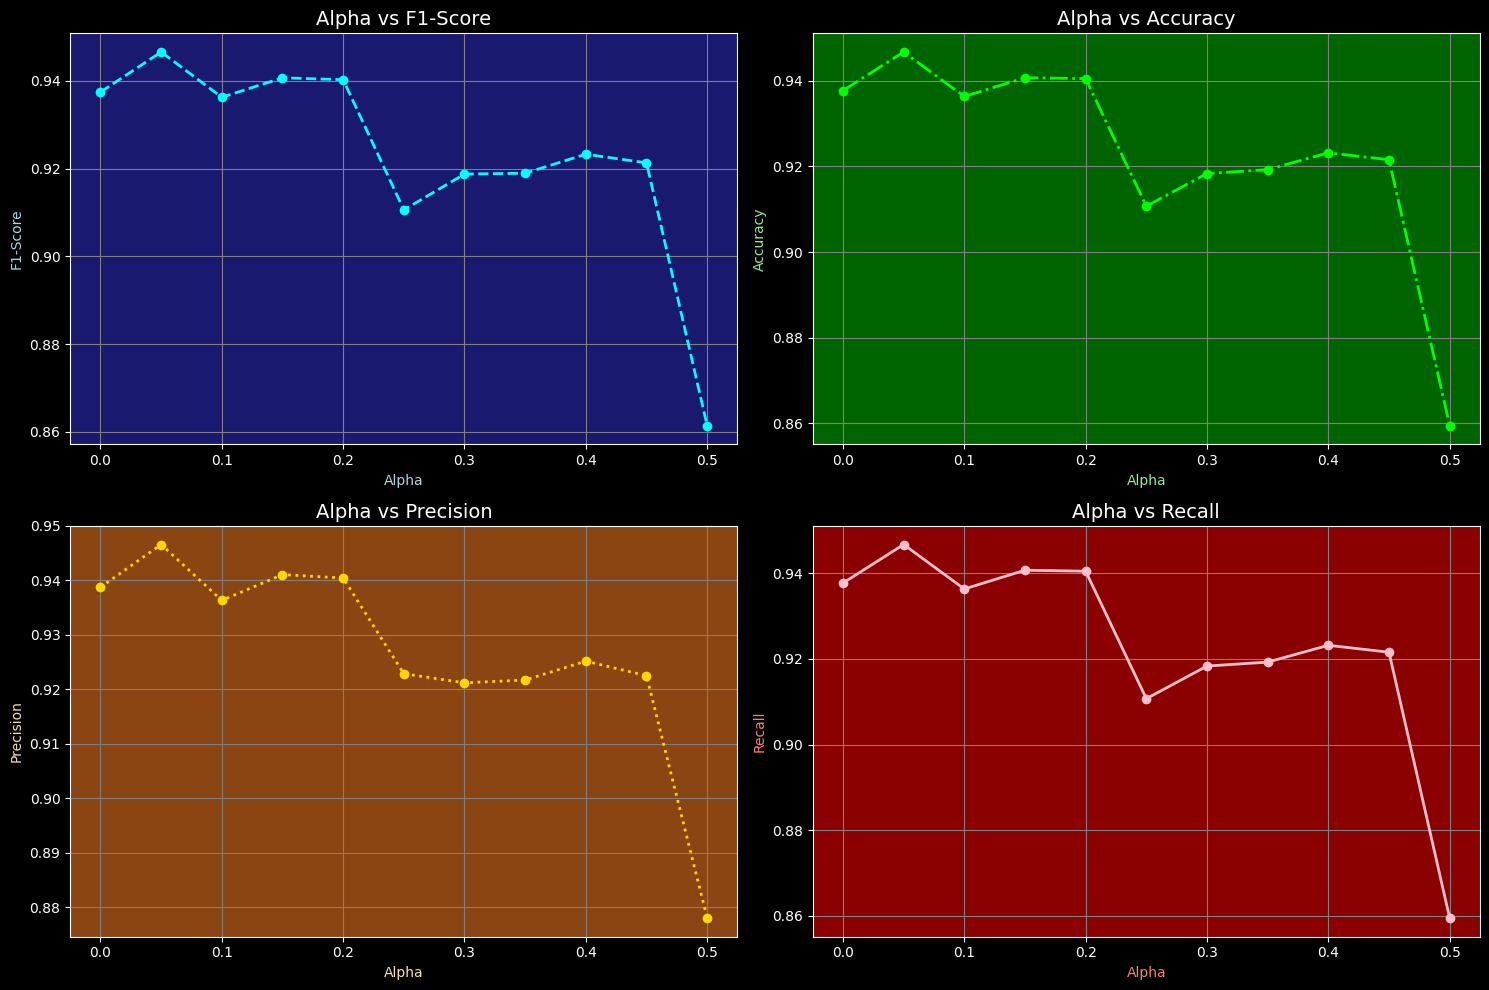

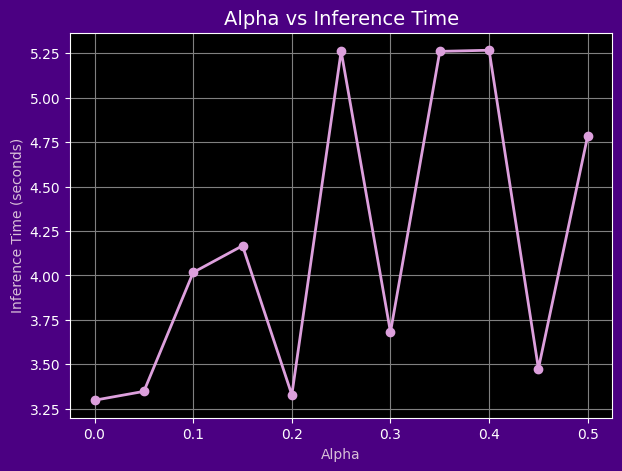

In [16]:
plt.style.use('dark_background')

plt.figure(figsize=(15, 10))

# Alpha vs F1-Score with a custom background color
plt.subplot(2, 2, 1, facecolor='midnightblue')
plt.plot(alpha_values, f1_scores, marker='o', color='cyan', linestyle='--', linewidth=2)
plt.title("Alpha vs F1-Score", fontsize=14, color='white')
plt.xlabel("Alpha", color='lightblue')
plt.ylabel("F1-Score", color='lightblue')
plt.grid(True, color='gray')

# Alpha vs Accuracy with a custom background color
plt.subplot(2, 2, 2, facecolor='darkgreen')
plt.plot(alpha_values, accuracies, marker='o', color='lime', linestyle='-.', linewidth=2)
plt.title("Alpha vs Accuracy", fontsize=14, color='white')
plt.xlabel("Alpha", color='lightgreen')
plt.ylabel("Accuracy", color='lightgreen')
plt.grid(True, color='gray')

# Alpha vs Precision with a custom background color
plt.subplot(2, 2, 3, facecolor='saddlebrown')
plt.plot(alpha_values, precisions, marker='o', color='gold', linestyle=':', linewidth=2)
plt.title("Alpha vs Precision", fontsize=14, color='white')
plt.xlabel("Alpha", color='wheat')
plt.ylabel("Precision", color='wheat')
plt.grid(True, color='gray')

# Alpha vs Recall with a custom background color
plt.subplot(2, 2, 4, facecolor='darkred')
plt.plot(alpha_values, recalls, marker='o', color='pink', linestyle='-', linewidth=2)
plt.title("Alpha vs Recall", fontsize=14, color='white')
plt.xlabel("Alpha", color='salmon')
plt.ylabel("Recall", color='salmon')
plt.grid(True, color='gray')

plt.tight_layout()
plt.show()

# Plot Inference Time vs. Alpha with custom background color separately
plt.figure(figsize=(7, 5), facecolor='indigo')
plt.plot(alpha_values, inference_times, marker='o', color='plum', linestyle='-', linewidth=2)
plt.title("Alpha vs Inference Time", fontsize=14, color='white')
plt.xlabel("Alpha", color='thistle')
plt.ylabel("Inference Time (seconds)", color='thistle')
plt.grid(True, color='gray')
plt.show()